# Training

## HGT
We used HGT Model: https://www.microsoft.com/en-us/research/publication/heterogeneous-graph-transformer/
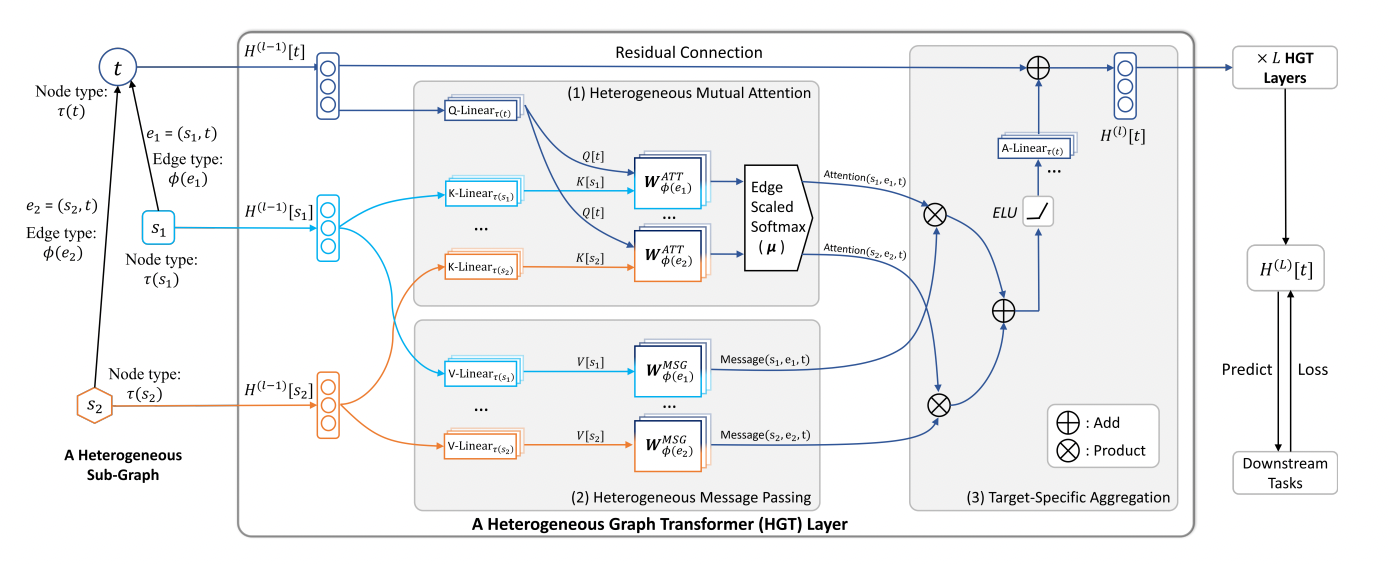
## Stochastic Training on Large Graphs
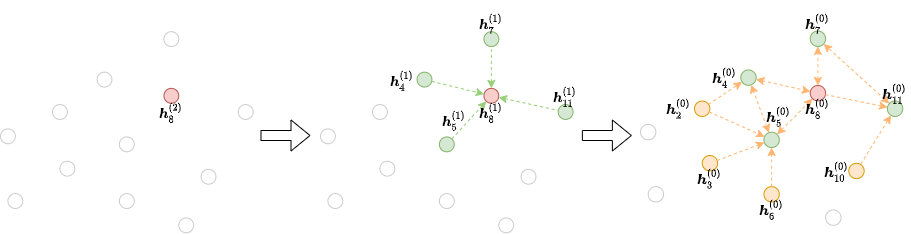
![Alt Text](https://data.dgl.ai/tutorial/img/sampling.gif)

In [1]:
import pandas as pd
import torch
import dgl
import pickle
from utils import HGT
import random

In [2]:
graph = dgl.load_graphs('training_data/graph.dgl')
graph = graph[0][0]

with open('training_data/train.obj', 'rb') as fp:
	train = pickle.load(fp)

with open('training_data/val.obj', 'rb') as fp:
	val = pickle.load(fp)

with open('training_data/test.obj', 'rb') as fp:
	test = pickle.load(fp)

In [3]:
graph.nodes('business').shape[0]

150243

In [4]:
edges = {}
for canonical_etype in graph.canonical_etypes:
    edges[canonical_etype] = graph.edges(etype=canonical_etype)

# we add the reversed relations
edges[('category', 'category_to_business', 'business')] = (graph.edges(etype='business_has_category')[1], graph.edges(etype='business_has_category')[0])
edges[('business', 'business_to_review', 'review')] = (graph.edges(etype='review_to_business')[1], graph.edges(etype='review_to_business')[0])
edges[('business', 'business_to_tip', 'tip')] = (graph.edges(etype='tip_to_business')[1], graph.edges(etype='tip_to_business')[0])
edges[('review', 'review_to_user', 'user')] = (graph.edges(etype='user_to_review')[1], graph.edges(etype='user_to_review')[0])
edges[('tip', 'tip_to_user', 'user')] = (graph.edges(etype='user_to_tip')[1], graph.edges(etype='user_to_tip')[0])

num_nodes_dict = {} 
for ntype in graph.ntypes:
    num_nodes_dict[ntype] = graph.nodes(ntype).shape[0]

g = dgl.heterograph(edges, num_nodes_dict = num_nodes_dict)
g.ndata['feat'] = {k: torch.tensor(v, dtype=torch.float32) for k, v in graph.ndata['feat'].items() }
del graph

/home/shared/jupyterenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [5]:
g.num_nodes

<bound method DGLGraph.num_nodes of Graph(num_nodes={'business': 150243, 'category': 1311, 'review': 6339837, 'tip': 908878, 'user': 1987897},
      num_edges={('business', 'business_has_category', 'category'): 668592, ('business', 'business_to_review', 'review'): 6339837, ('business', 'business_to_tip', 'tip'): 908878, ('category', 'category_to_business', 'business'): 668592, ('review', 'review_to_business', 'business'): 6339837, ('review', 'review_to_user', 'user'): 6339837, ('tip', 'tip_to_business', 'business'): 908878, ('tip', 'tip_to_user', 'user'): 908878, ('user', 'user_to_review', 'review'): 6339837, ('user', 'user_to_tip', 'tip'): 908878, ('user', 'user_to_user', 'user'): 437928},
      metagraph=[('business', 'category', 'business_has_category'), ('business', 'review', 'business_to_review'), ('business', 'tip', 'business_to_tip'), ('category', 'business', 'category_to_business'), ('review', 'business', 'review_to_business'), ('review', 'user', 'review_to_user'), ('tip', 'bus

In [6]:
node_dict = { ntype: g.ntypes.index(ntype) for ntype in g.ntypes }
edge_dict = { canonical_etype: g.canonical_etypes.index(canonical_etype) for canonical_etype in g.canonical_etypes }
feature_dim_dict = { ntype: g.ndata['feat'][ntype].shape[1] for ntype in g.ntypes }

In [7]:
node_dict

{'business': 0, 'category': 1, 'review': 2, 'tip': 3, 'user': 4}

In [8]:
model = HGT(node_dict, edge_dict, feature_dim_dict, n_hid=256, n_out=128, n_layers=4, n_heads=8, use_norm=False)
opt = torch.optim.AdamW(model.parameters(), 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.5)
sampler = dgl.dataloading.NeighborSampler([24, 24, 24, 24])
criterion = torch.nn.MarginRankingLoss(margin=1)
# dgl.dataloading.NeighborSampler([
#     {('user', 'follows', 'user'): 5,
#      ('user', 'plays', 'game'): 4,
#      ('game', 'played-by', 'user'): 3}] * 3)

In [9]:
train_pos_ids = list(range(train['pos'][0].shape[0]))
train_neg_ids = list(range(train['neg'][0].shape[0]))

In [10]:
val_pos_ids = list(range(val['pos'][0].shape[0]))
val_neg_ids = list(range(val['neg'][0].shape[0]))

In [11]:
len(train_neg_ids)

135108

In [12]:
g.ndata['feat']['category'].dtype

torch.float32

In [13]:
def predict(g, model, pos_ids, neg_ids, relation_tuple, sampler, batch_size):
    pos_users = torch.index_select(relation_tuple['pos'][0], 0, torch.tensor(pos_ids))
    pos_users_unique, pos_users_inverse = torch.unique(pos_users, return_inverse=True)
    pos_block_user = [blocks for _, _, blocks in dgl.dataloading.DataLoader(
        g, {'user': pos_users_unique}, sampler,
        batch_size=batch_size, shuffle=False, drop_last=False, num_workers=1)][0]

    pos_business = torch.index_select(relation_tuple['pos'][1], 0, torch.tensor(pos_ids))
    pos_business_unique, pos_business_inverse = torch.unique(pos_business, return_inverse=True)
    pos_block_business = [blocks for _, _, blocks in dgl.dataloading.DataLoader(
        g, {'business': pos_business_unique }, sampler,
        batch_size=batch_size, shuffle=False, drop_last=False, num_workers=1)][0]
    
    neg_users = torch.index_select(relation_tuple['neg'][0], 0, torch.tensor(neg_ids))
    neg_users_unique, neg_users_inverse = torch.unique(neg_users, return_inverse=True)
    neg_block_user = [blocks for _, _, blocks in dgl.dataloading.DataLoader(
        g, {'user': neg_users_unique }, sampler,
        batch_size=batch_size, shuffle=False, drop_last=False, num_workers=1)][0]
    
    neg_business = torch.index_select(relation_tuple['neg'][1], 0, torch.tensor(neg_ids))
    neg_business_unique, neg_business_inverse = torch.unique(neg_business, return_inverse=True)
    neg_block_business = [blocks for _, _, blocks in dgl.dataloading.DataLoader(
        g, {'business': neg_business_unique }, sampler,
        batch_size=batch_size, shuffle=False, drop_last=False, num_workers=1)][0]

    pos_user_logits = torch.index_select(model(pos_block_user, 'user'), 0, pos_users_inverse)
    pos_business_logits = torch.index_select(model(pos_block_business, 'business'), 0, pos_business_inverse)
    neg_user_logits = torch.index_select(model(neg_block_user, 'user'), 0, neg_users_inverse)
    neg_business_logits = torch.index_select(model(neg_block_business, 'business'), 0, neg_business_inverse)
    return pos_user_logits, pos_business_logits, neg_user_logits, neg_business_logits

In [14]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [15]:
len(list(zip(val_pos_ids, val_neg_ids)))

33777

In [16]:
def split(list_a, chunk_size):
    for i in range(0, len(list_a), chunk_size):
        yield list_a[i:i + chunk_size]

batch_size = 64
total_step_train = 0
best_val_loss = 100

In [ ]:
def split(list_a, chunk_size):
    for i in range(0, len(list_a), chunk_size):
        yield list_a[i:i + chunk_size]

batch_size = 64
total_step_train = 0
best_val_loss = 100
for epoch in range(20):
    model.train()
    random.shuffle(train_pos_ids)
    random.shuffle(train_neg_ids)
    # training
    losses = []
    for batch in split(list(zip(train_pos_ids, train_neg_ids)), batch_size):
        opt.zero_grad()
        pos_ids, neg_ids = list(zip(*batch))
        pos_user_logits, pos_business_logits, neg_user_logits, neg_business_logits = predict(g, model, pos_ids, neg_ids, train, sampler, batch_size)
        pos_score = torch.bmm(pos_user_logits.view(pos_user_logits.shape[0], 1, model.n_out), pos_business_logits.view(pos_user_logits.shape[0], model.n_out, 1)).squeeze()
        neg_score = torch.bmm(neg_user_logits.view(neg_user_logits.shape[0], 1, model.n_out), neg_business_logits.view(neg_user_logits.shape[0], model.n_out, 1)).squeeze()
        loss = criterion(pos_score, neg_score, torch.ones(pos_user_logits.shape[0]))
        loss.backward()
        opt.step()
        loss_value = loss.item()
        losses.append(loss_value)
        writer.add_scalar("Loss/train/batch", loss_value, total_step_train)
        total_step_train += 1
    writer.add_scalar("Loss/train", sum(losses) / len(losses), epoch)
    # validation
    model.eval()
    losses = []
    for batch in split(list(zip(val_pos_ids, val_neg_ids)), batch_size):
        with torch.no_grad():
            pos_ids, neg_ids = list(zip(*batch))
            pos_user_logits, pos_business_logits, neg_user_logits, neg_business_logits = predict(g, model, pos_ids, neg_ids, val, sampler, batch_size)
            pos_score = torch.bmm(pos_user_logits.view(pos_user_logits.shape[0], 1, model.n_out), pos_business_logits.view(pos_user_logits.shape[0], model.n_out, 1)).squeeze()
            neg_score = torch.bmm(neg_user_logits.view(neg_user_logits.shape[0], 1, model.n_out), neg_business_logits.view(neg_user_logits.shape[0], model.n_out, 1)).squeeze()
            loss_value = criterion(pos_score, neg_score, torch.ones(pos_user_logits.shape[0])).item()
            losses.append(loss_value)
    val_loss = (sum(losses) / len(losses))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
        }, 'models/best_model.pt')

    writer.add_scalar("Val/train", val_loss, epoch)
    writer.add_scalar("Scheduler", scheduler.get_last_lr()[0], epoch)
    scheduler.step()
    

/home/shared/jupyterenv/lib/python3.7/site-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


In [17]:
torch.save({ # sovrascritto per errore con un modello non allenato
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
}, 'models/last_model.pt')

In [18]:
model.load_state_dict(torch.load('models/best_model.pt')['model_state_dict'])

<All keys matched successfully>

## experiment

In [19]:
user_pos_id = train['pos'][0][0]

In [20]:
pos_business = train['pos'][1][train['pos'][0] == train['pos'][0][0]]
neg_business = train['neg'][1][train['neg'][0] == train['pos'][0][0]]

In [21]:
pos_business

tensor([111108,  80217,  25553,  73239,  66461,  23450,  20934, 120272,  86879,
         38967,  84152,  13612])

In [22]:
neg_business

tensor([120919])

In [23]:
user_df = pd.read_csv('preprocessed/user_ids.csv')
business_df = pd.read_csv('preprocessed/business_ids.csv')

In [24]:
user_df.loc[user_pos_id.tolist()]

user_id:ID    U438yUH5aBVntI_CbVt8jg
Name: 207300, dtype: object

In [25]:
business_df.loc[pos_business.tolist()]

,business_id:ID
111108,a0d09197752174e42a05ff2cf445fa91
80217,064a4a8a97aa17167a9427a19aca98ef
25553,33d2e8ccd5b8f4d14ad8e83b11444bc0
73239,3f2388115a0b7cc98b242191fdad7bf4
66461,8e64483dbe1cb3d0662df91b83867345
23450,1fd668fc67cb62812e523ab153b411ce
20934,f30c7b0034d553e0da7e07811841868b
120272,3d6954a8431403d9e6e8b293a943d6d2
86879,15aaec95654f4ba868dfb2547ec72193
38967,e1756e58d54f74ce2392ec5fe40d0eb5


In [26]:
business_df.loc[neg_business.tolist()]

,business_id:ID
120919,82ad544c4332ea410b5018b6b69b5a2d


In [27]:
model.eval()
block_user = [blocks for _, _, blocks in dgl.dataloading.DataLoader(
    g, {'user': [user_pos_id] }, sampler,
    batch_size=batch_size, shuffle=False, drop_last=False, num_workers=1)][0]

pos_block_business = [blocks for _, _, blocks in dgl.dataloading.DataLoader(
    g, {'business': pos_business }, sampler,
    batch_size=batch_size, shuffle=False, drop_last=False, num_workers=1)][0]

neg_block_business = [blocks for _, _, blocks in dgl.dataloading.DataLoader(
    g, {'business': neg_business }, sampler,
    batch_size=batch_size, shuffle=False, drop_last=False, num_workers=1)][0]

user = model(block_user, 'user')[0]
p_business = model(pos_block_business, 'business')
n_business = model(neg_block_business, 'business')


/home/shared/jupyterenv/lib/python3.7/site-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


In [28]:
torch.bmm(user.repeat(p_business.shape[0], 1).view(p_business.shape[0], 1, model.n_out), p_business.view(p_business.shape[0], model.n_out, 1)).squeeze()

tensor([11.3371, 10.7781, 10.6233, 11.0823, 11.0119, 10.7415, 10.9612, 10.3866,
        10.9540, 10.1368, 10.6800, 10.5832], grad_fn=<SqueezeBackward0>)

In [29]:
torch.bmm(user.repeat(n_business.shape[0], 1).view(n_business.shape[0], 1, model.n_out), n_business.view(n_business.shape[0], model.n_out, 1)).squeeze()

tensor(9.2826, grad_fn=<SqueezeBackward0>)

## Computing test metrics

In [30]:
test_pos_ids = list(range(test['pos'][0].shape[0]))
test_neg_ids = list(range(test['neg'][0].shape[0]))

In [31]:
test_pos_scores = []
test_neg_scores = []
model.eval()
for batch in split(list(zip(test_pos_ids, test_neg_ids)), batch_size):
    with torch.no_grad():
        pos_ids, neg_ids = list(zip(*batch))
        pos_user_logits, pos_business_logits, neg_user_logits, neg_business_logits = predict(g, model, pos_ids, neg_ids, test, sampler, batch_size)
        pos_score = torch.bmm(pos_user_logits.view(pos_user_logits.shape[0], 1, model.n_out), pos_business_logits.view(pos_user_logits.shape[0], model.n_out, 1)).squeeze()
        neg_score = torch.bmm(neg_user_logits.view(neg_user_logits.shape[0], 1, model.n_out), neg_business_logits.view(neg_user_logits.shape[0], model.n_out, 1)).squeeze()
        test_pos_scores.append(pos_score)
        test_neg_scores.append(neg_score)

In [37]:
test_pos_scores_ = torch.cat(test_pos_scores, 0)
test_neg_scores_ = torch.cat(test_neg_scores, 0)

In [39]:
print(test_pos_scores_.shape)
print(test_neg_scores_.shape)

torch.Size([8547])
torch.Size([8547])


In [40]:
test_scores = torch.cat((test_pos_scores_, test_neg_scores_), 0)

In [42]:
test_scores.shape

torch.Size([17094])

In [44]:
scaled_scores = (test_scores - test_scores.min()) / (test_scores.max() - test_scores.min())

In [72]:
test_scores.max()

tensor(15.1283)

In [73]:
test_scores.min()

tensor(0.0461)

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [48]:
torch.cat((torch.ones(test_pos_scores_.shape), torch.ones(test_neg_scores_.shape)), 0).numpy()

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [49]:
scaled_scores.numpy()

array([0.7069159 , 0.6954484 , 0.71746796, ..., 0.04083657, 0.52747077,
       0.59133947], dtype=float32)

In [56]:
from sklearn import metrics
y = torch.cat((torch.ones(test_pos_scores_.shape), torch.zeros(test_neg_scores_.shape)), 0).numpy()
pred = scaled_scores.numpy()
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)

In [57]:
fpr

array([0.        , 0.        , 0.        , ..., 0.88756289, 0.88779689,
       1.        ])

In [58]:
roc_auc

0.9311221666434022

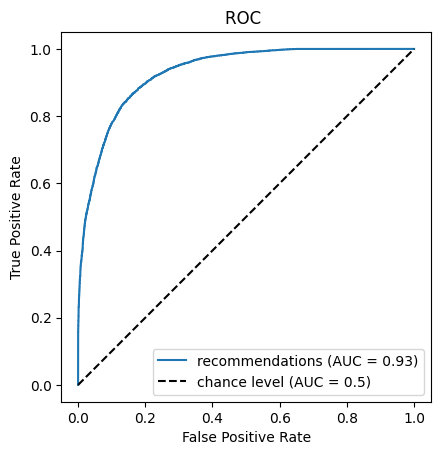

In [64]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                estimator_name='recommendations')

display.plot()
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC ")
plt.legend()
plt.show()

## mAP

https://www.google.com/url?sa=i&url=https%3A%2F%2Ftowardsdatascience.com%2Fmean-average-precision-at-k-map-k-clearly-explained-538d8e032d2&psig=AOvVaw3OigrCkXx711JIucna0RSQ&ust=1680360735139000&source=images&cd=vfe&ved=0CBEQjhxqFwoTCKCp6Nq1hv4CFQAAAAAdAAAAABAR
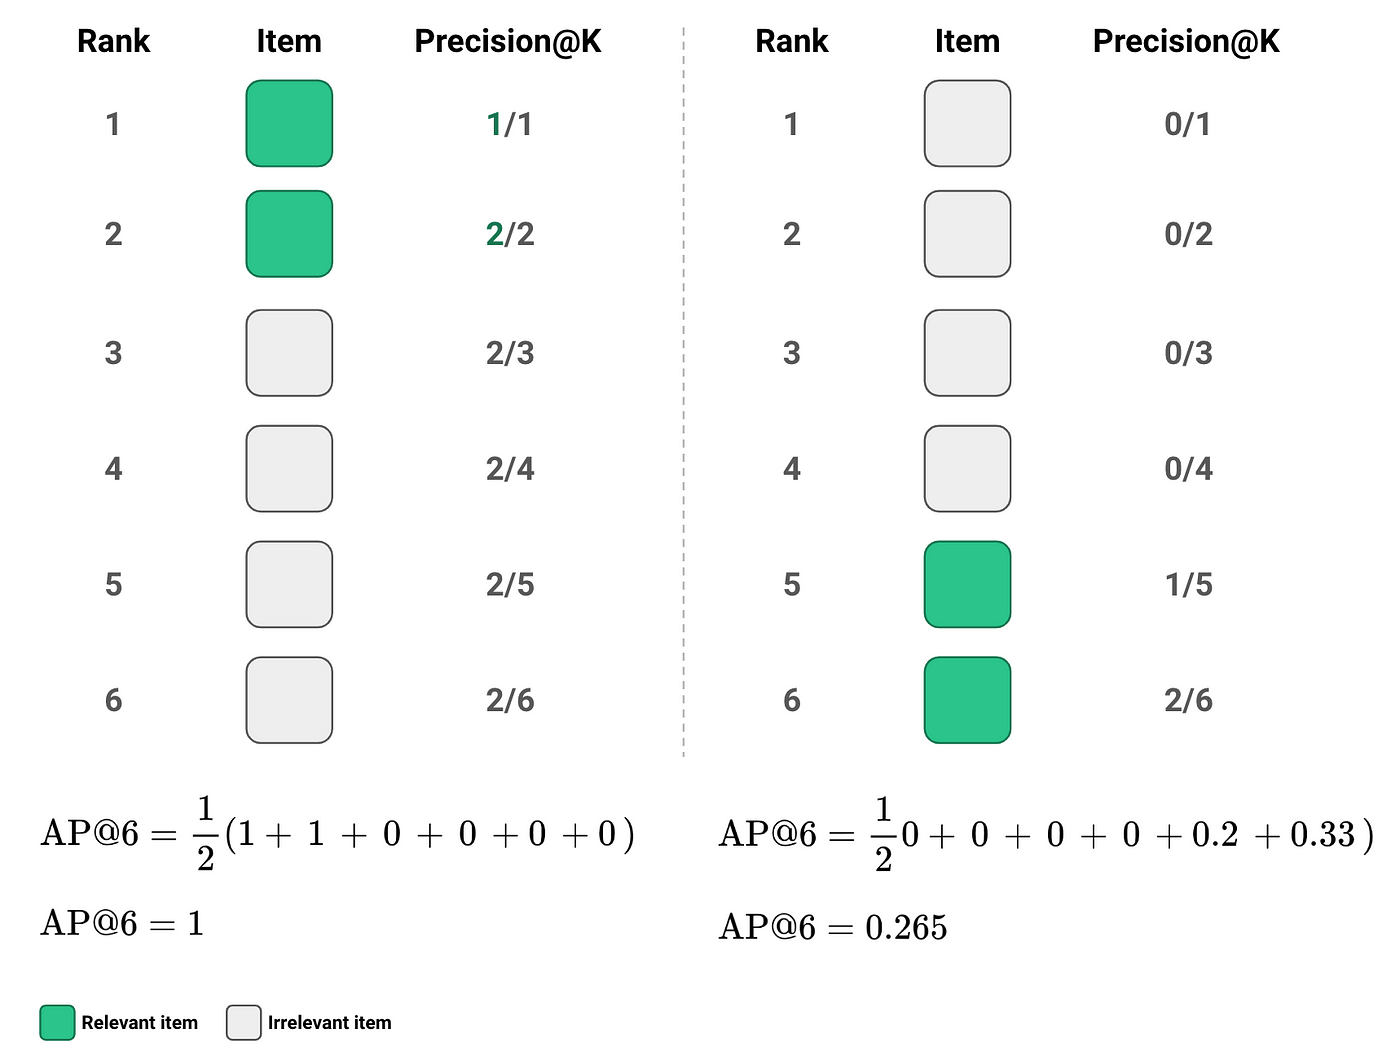

In [70]:
user_map = {}
model.eval()
for batch in split(list(zip(test_pos_ids, test_neg_ids)), batch_size):
    with torch.no_grad():
        pos_ids, neg_ids = list(zip(*batch))
        pos_user_logits, pos_business_logits, neg_user_logits, neg_business_logits = predict(g, model, pos_ids, neg_ids, test, sampler, batch_size)
        
        pos_users = torch.index_select(test['pos'][0], 0, torch.tensor(pos_ids))
        neg_users = torch.index_select(test['neg'][0], 0, torch.tensor(neg_ids))
        pos_score = torch.bmm(pos_user_logits.view(pos_user_logits.shape[0], 1, model.n_out), pos_business_logits.view(pos_user_logits.shape[0], model.n_out, 1)).squeeze()
        neg_score = torch.bmm(neg_user_logits.view(neg_user_logits.shape[0], 1, model.n_out), neg_business_logits.view(neg_user_logits.shape[0], model.n_out, 1)).squeeze()
        
        for i in range(pos_users.shape[0]):
            if pos_users[i].item() not in user_map:
                user_map[pos_users[i].item()] = {'scores': [], 'label': []}
            if neg_users[i].item() not in user_map:
                user_map[neg_users[i].item()] = {'scores': [], 'label': []}

            user_map[pos_users[i].item()]['scores'].append(pos_score[i].item())
            user_map[pos_users[i].item()]['label'].append(1)
            user_map[neg_users[i].item()]['scores'].append(neg_score[i].item())
            user_map[neg_users[i].item()]['label'].append(0)

In [175]:
count = 0
map_ids = []
for ids in user_map:
    if len(list(filter(lambda x: x == 1, user_map[ids]['label']))) >= 2 and len(list(filter(lambda x: x == 0, user_map[ids]['label']))) >= 2:
#        print(ids)
#        print(user_map[ids])
        map_ids.append(ids)
    

In [176]:
len(map_ids)

38

In [177]:
def precision_at_k(ordered_labels, k):
    # ordered_labels composed of only 0 or 1
    if len(ordered_labels) < k:
        raise Exception("k is bigger than the length of the list")
    
    return sum(ordered_labels[:k]) / k

In [178]:
precision_at_k([0, 0, 0, 0, 1, 1], 6)

0.3333333333333333

In [179]:
def average_precision_at_k(ordered_labels, k):
    if sum(ordered_labels[:k]) == 0:
        return 0
    return sum([precision_at_k(ordered_labels, i + 1) for i in range(k) if ordered_labels[i] == 1]) / sum(ordered_labels[:k])

In [180]:
average_precision_at_k([0, 0, 0, 0, 1, 1], 6)

0.26666666666666666

In [181]:
average_precision_at_k([1, 1, 0, 0, 0, 0], 6)

1.0

In [182]:
for i in list(zip(user_map[309276]['scores'], user_map[309276]['label'])):
    print(i)

(9.429422378540039, 1)
(10.139388084411621, 0)
(9.901885032653809, 0)
(10.06686782836914, 1)
(9.792681694030762, 1)
(10.852794647216797, 0)


In [183]:
ordered_labels = [l for _, l in sorted(zip(user_map[309276]['scores'], user_map[309276]['label']), reverse=True)]

In [184]:
[l for _, l in sorted(zip(user_map[309276]['scores'], user_map[309276]['scores']), reverse=True)]

[10.852794647216797,
 10.139388084411621,
 10.06686782836914,
 9.901885032653809,
 9.792681694030762,
 9.429422378540039]

In [185]:
ordered_labels

[0, 0, 1, 0, 1, 1]

In [186]:
def mAP(user_map, map_ids, k):
    maps = []
    for user_id in map_ids:
        ordered_labels = [l for _, l in sorted(zip(user_map[user_id]['scores'], user_map[user_id]['label']), reverse=True)]
        maps.append(average_precision_at_k(ordered_labels, k))
    return sum(maps) / len(maps)

In [187]:
mAP(user_map, map_ids, 3)

0.8684210526315788

In [188]:
def negative_mAP(user_map, map_ids, k):
    maps = []
    for user_id in map_ids:
        ordered_labels = [l for _, l in sorted(zip(user_map[user_id]['scores'], user_map[user_id]['label']))]
        ordered_labels = [(x + 1) % 2 for x in ordered_labels]
        maps.append(average_precision_at_k(ordered_labels, k))
    return sum(maps) / len(maps)

In [189]:
negative_mAP(user_map, map_ids, 3)

0.8092105263157893